In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import logging as log
from utils.preprocessing import Shaper, MinMaxScaler, minmax_scale
from utils.configs import BaseConf


# todo add set of valid / living sells / to be able to sample the right ones
class CrimeDataGroup:
    """
    Collection of datasets (training/validation/test)
    """

    def __init__(self, data_path, conf):
        """
        Args:
            data_path (string): Path to the data folder with all spatial and temporal data.
        """
        # todo normalise the data
        # todo cap the crime grids at a certain level - instead use np.log2(1 + x) to normalise
        # dont use function to get values each time - create join and add table
        # [√] number of incidents of crime occurrence by sampling point in 2013 (1-D)
        # [√] number of incidents of crime occurrence by census tract in 2013 (1-D)
        # [√] number of incidents of crime occurrence by census tract yesterday (1-D).
        # [√] number of incidents of crime occurrence by date in 2013 (1-D)

        zip_file = np.load(data_path + "generated_data.npz")

        # print info on the read data
        log.info("Data shapes of files in generated_data.npz")
        for k, v in zip_file.items():
            log.info(f"{k} shape {np.shape(v)}")

        self.shaper = Shaper(data=zip_file["crime_types_grids"])

        # squeeze all spatially related data
        self.crimes = self.shaper.squeeze(zip_file["crime_types_grids"])  # reshaped into (N, C, L)

        self.total_crimes = self.crimes[:, 0].sum(1)



        self.tract_count_grids = self.shaper.squeeze(zip_file["tract_count_grids"])
        self.demog_grid = self.shaper.squeeze(zip_file["demog_grid"])
        self.street_grid = self.shaper.squeeze(zip_file["street_grid"])

        self.time_vectors = zip_file["time_vectors"]
        self.x_range = zip_file["x_range"]
        self.y_range = zip_file["y_range"]
        self.t_range = pd.read_pickle(data_path + "t_range.pkl")

        self.seq_len = conf.seq_len

        self.total_len = len(self.t_range)  # length of the whole time series

        #  sanity check if time matches up with our grids
        if len(self.t_range) != len(self.crimes):
            log.error("time series and time range lengths do not match up -> " +
                      "len(self.t_range) != len(self.crime_types_grids)")
            raise RuntimeError

        val_size = int(self.total_len * conf.val_ratio)
        tst_size = int(self.total_len * conf.tst_ratio)

        trn_index = (0, self.total_len - tst_size - val_size)
        val_index = (trn_index[1], self.total_len - tst_size)
        tst_index = (val_index[1], self.total_len)

        self.scaler = MinMaxScaler(feature_range=(0, 1))

        # todo check if time independent  values aren't copied every time
        self.training_set = CrimeDataset(
            crimes=self.crimes[trn_index[0]:trn_index[1]],
            t_range=self.t_range[trn_index[0]:trn_index[1]],
            time_vectors=self.time_vectors[trn_index[0]:trn_index[1]],
            tract_count_grids=self.tract_count_grids,
            demog_grid=self.demog_grid,
            street_grid=self.street_grid,
            seq_len=self.seq_len,
        )

        self.validation_set = CrimeDataset(
            crimes=self.crimes[val_index[0]:val_index[1]],
            t_range=self.t_range[val_index[0]:val_index[1]],
            time_vectors=self.time_vectors[val_index[0]:val_index[1]],
            tract_count_grids=self.tract_count_grids,
            demog_grid=self.demog_grid,
            street_grid=self.street_grid,
            seq_len=self.seq_len,
        )

        self.testing_set = CrimeDataset(
            crimes=self.crimes[tst_index[0]:tst_index[1]],
            t_range=self.t_range[tst_index[0]:tst_index[1]],
            time_vectors=self.time_vectors[tst_index[0]:tst_index[1]],
            tract_count_grids=self.tract_count_grids,
            demog_grid=self.demog_grid,
            street_grid=self.street_grid,
            seq_len=self.seq_len,
        )


class CrimeDataset(Dataset):
    def __init__(
            self,
            crimes,  # time and space dependent
            t_range,  # time dependent
            time_vectors,  # time dependent
            tract_count_grids,  # space dependent
            demog_grid,  # space dependent
            street_grid,  # space dependent
            seq_len,

    ):
        # normalize
        self.seq_len = seq_len

        self.crimes = crimes[:-1]  # inputs
        self.t_size, _, self.l_size = np.shape(self.crimes)

        self.targets = np.copy(crimes[1:])
        self.targets[self.targets > 1] = 1

        self.tract_count_grids = tract_count_grids  # mostly for kang and kang
        self.demog_grid = demog_grid
        self.street_grid = street_grid

        self.time_vectors = time_vectors[:-1]
        self.t_range = t_range[:-1]  # time of the input crime not the prediction

        self.total_crimes = self.crimes[:, 0].sum(1)  # or self.crime_types_grids[0].sum(1).sum(1)

    # todo add weather -  remember weather should be the info of the next time step

    def __len__(self):
        """Denotes the total number of samples"""
        return (self.t_size - self.seq_len) * self.l_size

    def __getitem__(self, index):
        """Generates one sample of data"""
        t_index, l_index = np.unravel_index(index, (self.t_size, self.l_size))

        # todo teacher forcing - if we are using this then we need to return sequence of targets
        feats = self.crimes[t_index:t_index + self.seq_len, :, l_index]
        target = self.targets[t_index:t_index + self.seq_len, :, l_index]

        # when using no teacher forcing
        # target = self.targets[t+self.seq_len, :, l]
        # todo add all other data
        # [√] number of incidents of crime occurrence by sampling point in 2013 (1-D)
        # [√] number of incidents of crime occurrence by census tract in 2013 (1-D)
        # [√] number of incidents of crime occurrence by census tract yesterday (1-D).
        # [√] number of incidents of crime occurrence by date in 2013 (1-D)


        return feats, target


In [26]:
data_dim_str = "T24H-X850M-Y880M"  # needs to exist
data_path = f"./data/processed/{data_dim_str}/"    


conf_dict = {
    "seed":3,
    "resume":False,
    "early_stopping":False,
    "use_weighted_sampler":True,
    "use_cuda":False,
    "val_ratio":0.1,
    "tst_ratio":0.2,
    "lr":1e-3,
    "weight_decay":1e-8,
    "max_epochs":10,
    "batch_size":80,
    "shuffle":False,
    "num_workers":6,
    "seq_len":0,
}

conf = BaseConf(conf_dict=conf_dict)

In [27]:
datagroup = CrimeDataGroup(data_path=data_path, conf=conf)

2019-08-16T15:02:54 | root | INFO | Data shapes of files in generated_data.npz
2019-08-16T15:02:54 | root | INFO | crime_feature_indices shape (11,)
2019-08-16T15:02:54 | root | INFO | crime_types_grids shape (366, 11, 47, 33)
2019-08-16T15:02:54 | root | INFO | crime_grids shape (366, 1, 47, 33)
2019-08-16T15:02:54 | root | INFO | demog_grid shape (1, 37, 47, 33)
2019-08-16T15:02:54 | root | INFO | street_grid shape (1, 512, 47, 33)
2019-08-16T15:02:54 | root | INFO | time_vectors shape (366, 43)
2019-08-16T15:02:54 | root | INFO | weather_vectors shape (365, 11)
2019-08-16T15:02:54 | root | INFO | x_range shape (33,)
2019-08-16T15:02:54 | root | INFO | y_range shape (47,)


KeyError: 'tract_count_grids is not a file in the archive'

In [28]:
zip_file = np.load(data_path + "generated_data.npz")

crime_feature_indices = zip_file["crime_feature_indices"]
crime_types_grids = zip_file["crime_types_grids"]
crime_grids = zip_file["crime_grids"]
demog_grid = zip_file["demog_grid"]
street_grid = zip_file["street_grid"]
time_vectors = zip_file["time_vectors"]
weather_vectors = zip_file["weather_vectors"]
x_range = zip_file["x_range"]
y_range = zip_file["y_range"]

0.0


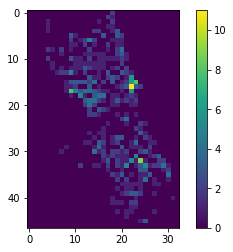

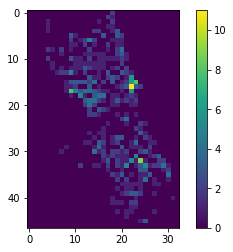

In [33]:
from utils.plots import im
import matplotlib.pyplot as plt
import pandas as pd


print(np.sum(crime_types_grids[:,0] - crime_grids[:,0]))
im(crime_types_grids[0, 0])
plt.show()
im(crime_grids[0, 0])
plt.show()

In [39]:
for k,v in zip_file.items():
    print(f"{k} shape {np.shape(v)}")
    
t_range = pd.read_pickle(data_path + "t_range.pkl")    
print(f"t_range shape {np.shape(t_range)}")

crime_feature_indices shape (11,)
crime_types_grids shape (366, 11, 47, 33)
crime_grids shape (366, 1, 47, 33)
demog_grid shape (1, 37, 47, 33)
street_grid shape (1, 512, 47, 33)
time_vectors shape (366, 43)
weather_vectors shape (365, 11)
x_range shape (33,)
y_range shape (47,)
t_range shape (366,)


In [ ]:
def make_grid(A, t_size, x_size, y_size):
    """
    Note: np.histogramdd() can also be used - it's a bit
    A: matrix with time, x and y coordinates
    returns grid matrix with each index filled where crimes occurred
    X and Y axis are swapped to make displaying easier
    """
    grids = np.zeros((t_size, y_size, x_size))
    for a in A:
        grids[a[0], y_size - 1 - a[2], a[1]] += 1

    return grids


In [47]:
from datetime import datetime
import os
from matplotlib import rcParams
import matplotlib.pyplot as plt
from utils.utils import *
from utils.data_processing import *
import logging as log
from logger.logger import setup_logging

{'disable_existing_loggers': True,
 'formatters': {'datetime': {'datefmt': '%Y-%m-%dT%H:%M:%S',
                             'format': '%(asctime)s | %(name)s | %(levelname)s '
                                       '| %(message)s'},
                'simple': {'datefmt': '%Y-%m-%dT%H:%M:%S',
                           'format': '%(asctime)s | %(name)s | %(levelname)s | '
                                     '%(message)s'}},
 'handlers': {'console': {'class': 'logging.StreamHandler',
                          'formatter': 'simple',
                          'level': 'DEBUG',
                          'stream': 'ext://sys.stdout'},
              'info_file_handler': {'backupCount': 20,
                                    'class': 'logging.handlers.RotatingFileHandler',
                                    'encoding': 'utf8',
                                    'filename': 'logs.log',
                                    'formatter': 'datetime',
                                    'level': 

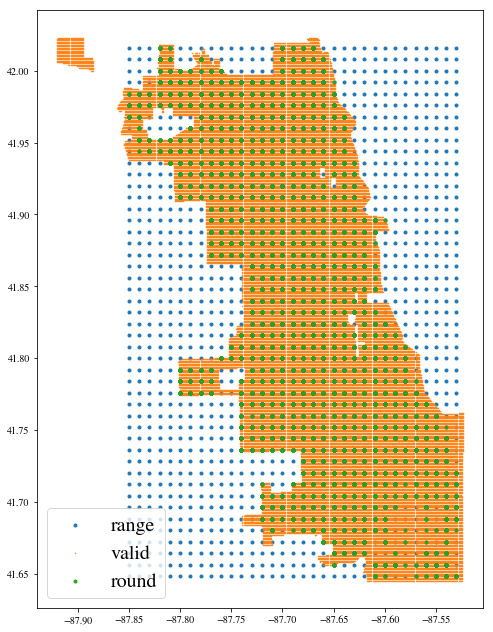

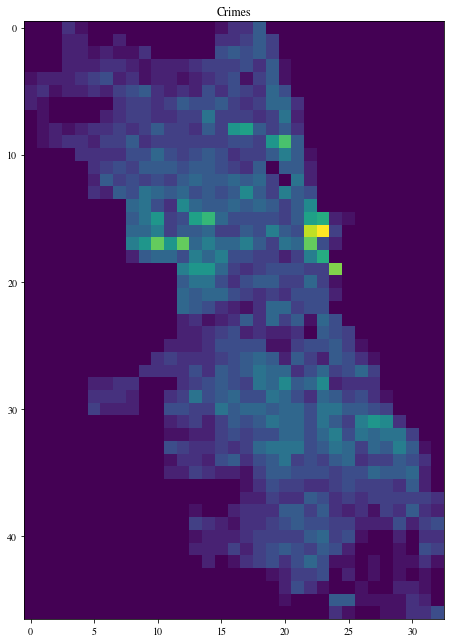

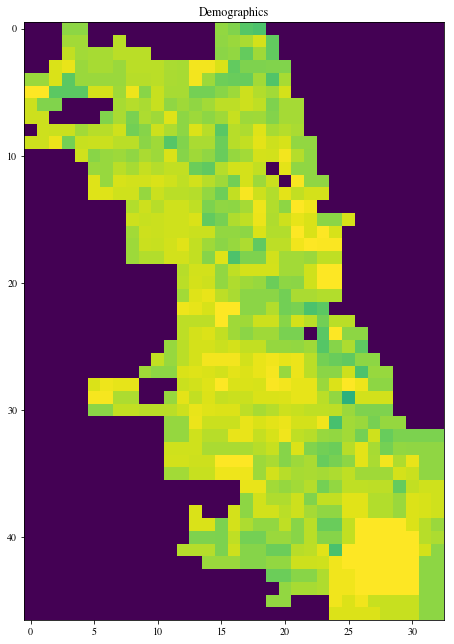

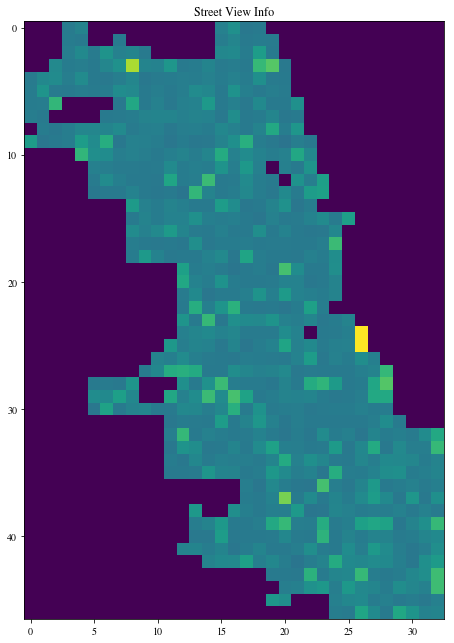

In [27]:
import os
from matplotlib import rcParams
import matplotlib.pyplot as plt
from utils.utils import *
from utils.data_processing import *
import logging as log
from logger.logger import setup_logging

if __name__ == "__main__":
    setup_logging(save_dir="./logs/", file_name="generate_data.log")
    log.info("=====================================BEGIN=====================================")
    # set the plotting format
    rcParams['mathtext.fontset'] = 'stix'
    rcParams['font.family'] = 'STIXGeneral'

    # set all values from the config
    config = read_json("./config/generate_data.json")
    dT = config["dT"]
    scale = config["scale"]  # scale the area

    # used as info file for the folder where the data is created
    info = dict()
    info["createdOn"] = datetime.now().strftime("%Y%m%dT%H%M")
    load_folder_raw = "./data/raw/"
    load_folder_original = "./data/original/"

    ######################################################
    #                     LOAD DATA                      #
    ######################################################
    # external information (demographic and weather)
    weather_minmax_normed = pd.read_pickle(load_folder_raw + "weather_minmax_normed.pkl")
    weather_vectors = weather_minmax_normed.iloc[:, 1:].values  # not these are only weather values for 2014
    # todo is this needed or do we get all info from point2spatial_info
    # census = pd.read_pickle(load_folder + "census_minmax_normed.pkl")

    # physical coords and their tracts
    valid_points = np.load(load_folder_raw + "valid_points.npy")
    valid_tracts = np.load(load_folder_raw + "valid_tracts.npy")
    invalid_tracts = np.load(load_folder_raw + "invalid_tracts.npy")
    tract2points = pd.read_pickle(load_folder_raw + "tract2points.pkl")
    point2tract = pd.read_pickle(load_folder_raw + "point2tract.pkl")
    tract_boundaries = pd.read_pickle(load_folder_raw + "tract_boundaries.pkl")
    tract2km2 = pd.read_pickle(load_folder_raw + "tract2km2.pkl")

    # link between points and demographic data
    point2spatial_info = pd.read_pickle(load_folder_raw + "point2spatial_info.pkl")  # todo is this normalised?

    ######################################################
    #                PREPROCESS DATA                     #
    ######################################################
    # Time dimensions
    info["dT"] = dT
    # Spatial dimensions
    xy_scale = scale * np.array([10, 8])  # must be integer so that we can easily sample demographic data
    dx, dy = xy_scale * np.array([0.001, 0.001])
    info["dx"] = float(dx)
    info["dy"] = float(dy)
    info["x in metres"] = 85000 * float(dx)
    info["y in metres"] = 110000 * float(dy)

    log.info("Cell sizes: %.3f m in x direction and %.3f m in y direction" % (85000 * dx, 110000 * dy))

    crimes = pd.read_pickle(load_folder_raw + "crimes_2012_to_2018.pkl")

    # CHOOSE CRIME TYPES
    valid_crime_types = [
        "THEFT",
        "BATTERY",
        "CRIMINAL DAMAGE",
        "NARCOTICS",
        "ASSAULT",
        "BURGLARY",
        "MOTOR VEHICLE THEFT",
        "ROBBERY",
    ]
    # filter useless crime types
    crimes = crimes[crimes["Primary Type"].isin(valid_crime_types)]

    # take out western most tract to simplify things for the cnn
    crimes = crimes[crimes.tract != 7706.02]

    start_date = config["start_date"]
    end_date = config["end_date"]
    info["start_date"] = start_date
    info["end_date"] = end_date

    t_range = pd.date_range(start_date, end_date, freq=dT)
    crimes = crimes[crimes.Date < t_range[-1]]  # choose only crimes which lie in the valid time range
    crimes = crimes[crimes.Date >= t_range[0]]  # choose only crimes which lie in the valid time range
    # crimes.Date = crimes.Date.dt.floor(dT) # DON"T ROUND,
    # ONLY FLOOR, OTHERWISE THE WEATHER DATA DOESNT LINE UP PROPERLY.

    t_min = pd.Series(crimes.Date.min()).astype(np.int64)[0]
    dt = pd.Series(t_range[1] - t_range[0]).astype(np.int64)[0]

    t = crimes.Date.astype(np.int64)
    t = t - t_min
    t = t // dt
    crimes["t"] = t

    x_max_valid, y_max_valid = valid_points.max(0)
    x_min_valid, y_min_valid = valid_points.min(0)

    # we know all crimes have defined demographics
    # spatial discritization with step
    crimes["X"] = crimes.Longitude
    crimes["Y"] = crimes.Latitude

    # round Long and Lat to nearest increment of dx and dy
    # all spots are defined?

    crimes.X = np.round(crimes.X / dx) * dx
    crimes.Y = np.round(crimes.Y / dy) * dy

    crimes.X = np.round(crimes.X, decimals=3)  # used to make sure we can still hash coords
    crimes.Y = np.round(crimes.Y, decimals=3)  # rounding ensures floating point issues are dealt with

    log.info(f"Number of total crimes: {len(crimes)}")
    crimes = crimes[
        (crimes.X <= x_max_valid) & (crimes.X >= x_min_valid) & (crimes.Y >= y_min_valid) & (crimes.Y <= y_max_valid)]
    log.info(f"Number of crimes in valid spatial range: {len(crimes)}")

    # x_range = np.arange(crimes.X.min(),crimes.X.max()+dx,dx)
    # .001 because that is our smallest element dx can be bigger
    # y_range = np.arange(crimes.Y.min(),crimes.Y.max()+dy,dy)
    x_min, x_max = crimes.X.min(), crimes.X.max()
    y_min, y_max = crimes.Y.min(), crimes.Y.max()

    # .001 because that is our smallest element dx can be bigger
    x_range = np.arange(crimes.X.min(), np.round(crimes.X.max() + dx, decimals=3), dx)
    y_range = np.arange(crimes.Y.min(), np.round(crimes.Y.max() + dy, decimals=3), dy)

    x_range = x_range.round(decimals=3)  # used to make sure we can still hash coords
    y_range = y_range.round(decimals=3)

    # filter because of floating point issues
    x_range = x_range[(x_range >= x_min) & (x_range <= x_max)]
    y_range = y_range[(y_range >= y_min) & (y_range <= y_max)]

    x_min, x_max = x_range[0], x_range[-1]
    y_min, y_max = y_range[0], y_range[-1]

    crimes["x"] = np.array(np.round((crimes.X - x_min) / dx), dtype=int)
    crimes["y"] = np.array(np.round((crimes.Y - y_min) / dy), dtype=int)

    # only take crimes that land on nodes that have demographic info
    all_crime_spots = crimes[["X", "Y"]].values
    crimes["xy"] = list(map(tuple, all_crime_spots))
    valid_crime_spots = set2d(crimes[["X", "Y"]].values) - (set2d(crimes[["X", "Y"]].values) - set2d(valid_points))
    drop_crime_spots = list(set2d(all_crime_spots) - valid_crime_spots)
    valid_crime_spots = np.array(list(valid_crime_spots))

    indices_to_drop = []

    for i in range(len(drop_crime_spots)):
        log.info(f"dropped {i}")
        indices = crimes[crimes.xy == drop_crime_spots[i]].index
        crimes.drop(index=indices, inplace=True)

    log.info(f"Number of crimes valid spatial range and on nodes with demographic info: {len(crimes)}")

    X, Y = np.meshgrid(x_range, y_range)
    # crimes["Primary Type"].value_counts()
    t_size = len(t_range) - 1  # dates are an extra one - the range indicates start and end walls of each cell
    x_size = len(x_range)  # x_range are the means of each cell
    y_size = len(y_range)  # y_range are the means of each cell

    log.info(f"t_size:\t{t_size}\nx_size:\t{x_size}\ny_size:\t{y_size}")

    A = crimes[["t", "x", "y"]].values[:]

    log.info(f"A.shape -> {A.shape}")
    log.info(f"t_size, x_size, y_size -> {t_size}, {x_size}, {y_size}")
    log.info(f"crimes.t.max(), crimes.x.max(), crimes.y.max() -> {crimes.t.max()}, {crimes.x.max()},{crimes.y.max()}")
    log.info(f"t_range[-1] -> {t_range[-1]}")
    log.info(f"t_range[0] -> {t_range[0]}")

    info["t_size"] = t_size
    info["x_size"] = x_size
    info["y_size"] = y_size

    info["crimes.t.max()"] = int(crimes.t.max())
    info["crimes.t.min()"] = int(crimes.t.min())
    info["crimes.x.max()"] = int(crimes.x.max())
    info["crimes.x.min()"] = int(crimes.x.min())
    info["crimes.y.max()"] = int(crimes.y.max())
    info["crimes.y.min()"] = int(crimes.y.min())

    crime_grids = make_grid(A, t_size, x_size, y_size)

    ######################################################
    #          TRACTS GRIDS DATA GENERATION               #
    ######################################################
    # Creates Grid where the cell value is the total crime in that tract for that time step
    tract2index = {}
    for i, tr in enumerate(valid_tracts):
        tract2index[tr] = i

    trindex = []
    for tr in crimes.tract.values:
        trindex.append(tract2index[tr])

    crimes['trindex'] = trindex
    tracts = np.zeros((t_size, len(valid_tracts)))  # crime count in tracts over time - can be used for lstm

    tract_info = crimes[['t', 'trindex']].values

    for t, tr in tract_info:
        tracts[t, tr] += 1

    # make grid by the number of crimes in that tract
    tract_count_grids = np.zeros_like(crime_grids)

    # for x, y in valid_crime_spots:  # leads to some missing data
    for x, y in valid_points:
        tr = point2tract[x, y]
        if x in x_range and y in y_range:
            x = np.argwhere(x_range == x)[0, 0]
            y = np.argwhere(y_range == y)[0, 0]
            info_ = tracts[:, tract2index[tr]]
            tract_count_grids[:, y_size - y - 1, x] = np.array(info_)

    ######################################################
    #          DEMOGRAPHIC DATA GENERATION               #
    ######################################################
    # todo implement interpolation for this as well.

    num_demog_feats = 37
    demog_grid = np.zeros((num_demog_feats, y_size, x_size))  # grids with demographic info

    err = []
    for x in range(x_size):
        for y in range(y_size):
            X_ = x_range[x]
            Y_ = y_range[y]
            try:
                demog_grid[:, y_size - y - 1, x] = np.array(
                    point2spatial_info[X_, Y_])  # should be redone with filtered census data
            except KeyError:
                err.append((X_, Y_))

    log.info(f"sum(demog_grid):\t {demog_grid.sum()}")
    log.info(f"x_size*y_size:\t\t {x_size * y_size}")
    log.info(f"len(err):\t\t {len(err)}")

    # street view vectors
    # some cells do not have coordinates
    # we use pca to compress the feature vector (pca not necessarily needed)
    # knn to fill in featureless cell with the values of the closest feature full cell
    point2feats_res18 = pd.read_pickle(load_folder_raw + "point2feats_res18.pkl")

    from sklearn.decomposition import PCA

    coords = np.array(list(point2feats_res18.keys()))
    feats = np.array(list(point2feats_res18.values()))

    n_components = 512

    pca = PCA(n_components=n_components)
    c = pca.fit_transform(feats)
    c = (c - c.min()) / (c.max() - c.min())

    from sklearn.neighbors import KNeighborsRegressor

    knn = KNeighborsRegressor(n_neighbors=1, weights="uniform")
    knn.fit(coords, c)
    valid_feats = knn.predict(valid_points)

    point2feats = dict()
    for i, (x, y) in enumerate(valid_points):
        point2feats[x, y] = valid_feats[i]

    street_grid = np.zeros((n_components, y_size, x_size))  # grids with demographic info
    err = []
    for x in range(x_size):
        for y in range(y_size):
            X_ = x_range[x]
            Y_ = y_range[y]
            try:
                street_grid[:, y_size - y - 1, x] = np.array(
                    point2feats[X_, Y_])  # should be redone with filtered census data
            except KeyError:
                err.append((X_, Y_))

    log.info(f"sum(street_grid):\t {street_grid.sum()}")
    log.info(f"x_size*y_size:\t\t {x_size * y_size}")
    log.info(f"len(err):\t\t {len(err)}")

    #########################################################################
    #                           CRIME TYPES GRID                            #
    #########################################################################

    c2i = {"THEFT": 0,
           "BATTERY": 1,
           "CRIMINAL DAMAGE": 2,
           "NARCOTICS": 3,
           "ASSAULT": 4,
           "BURGLARY": 5,
           "MOTOR VEHICLE THEFT": 6,
           "ROBBERY": 7}  # can also change the values to group certain crimes into a class


    #                       - like battery and assault into a type and theft and robbery and
    #                       motor vehicle theft into a type and narcotics into another type.

    # OTHER OPTIONS
    # c2i = {"THEFT":0,
    # "BATTERY":1,
    # "CRIMINAL DAMAGE":2,
    # "NARCOTICS":3,
    # "ASSAULT":1,
    # "BURGLARY":0,
    # "MOTOR VEHICLE THEFT":0,
    # "ROBBERY":0} # can

    # OTHER OPTIONS
    # c2i = {"THEFT":0,
    # "BATTERY":1,
    # "NARCOTICS":2}

    def type2index(crime_type):
        try:
            r = c2i[crime_type]
        except KeyError:
            r = 8  # all other types are translated to 8

        return r


    crimes["c"] = crimes["Primary Type"].apply(type2index)

    # FILTER BY CRIME TYPE
    crimes = crimes[crimes.c < 8]

    # ONE HOT ENCODING FOR THE CRIME TYPES
    ohe = np.zeros((len(crimes), 8), dtype=int)
    for i, c in enumerate(crimes.c):
        ohe[i, c] = 1

    for i, k in enumerate(c2i):
        crimes[k] = ohe[:, i]

    crimes["TOTAL"] = np.ones(len(crimes), dtype=int)

    # INCLUDE ARRESTS
    crimes["Arrest"] = crimes["Arrest"] * 1

    # crime_feature_indices = {
    #     0: "TOTAL",
    #     1: "THEFT",
    #     2: "BATTERY",
    #     3: "CRIMINAL DAMAGE",
    #     4: "NARCOTICS",
    #     5: "ASSAULT",
    #     6: "BURGLARY",
    #     7: "MOTOR VEHICLE THEFT",
    #     8: "ROBBERY",
    #     9: "Arrest"
    # }

    crime_feature_indices = [
        "TOTAL",
        "THEFT",
        "BATTERY",
        "CRIMINAL DAMAGE",
        "NARCOTICS",
        "ASSAULT",
        "BURGLARY",
        "MOTOR VEHICLE THEFT",
        "ROBBERY",
        "Arrest"]

    A = crimes[["t", "x", "y", "TOTAL", "THEFT", "BATTERY", "CRIMINAL DAMAGE", "NARCOTICS", "ASSAULT", "BURGLARY",
                "MOTOR VEHICLE THEFT", "ROBBERY", "Arrest"]].values
    # A = crimes[["t","b","TOTAL","THEFT", "BATTERY", "NARCOTICS","Arrest"]].values # is used when x and y are flattened

    crime_type_grids = np.zeros((t_size, A.shape[-1] - 3, y_size, x_size))

    for a in A:
        crime_type_grids[a[0], :, y_size - 1 - a[2], a[1]] += a[3:]  # todo normalize in channels

    # Adding any crime related data to the channels, e.g. tract counts if we want to
    crime_feature_indices.append("tract total")
    tract_count_grids = np.expand_dims(tract_count_grids, axis=1)

    try:
        crime_type_grids = np.concatenate((crime_type_grids, tract_count_grids), axis=1)
    except ValueError as e:
        err_msg = f"crime_type_grids: {np.shape(crime_type_grids)}, tract_count_grids: {np.shape(tract_count_grids)}"
        log.error(err_msg)
        raise ValueError(f"{e} -> {err_msg}")

    #########################################################################
    #                            SAVE DATA                                  #
    #########################################################################
    save_folder = f"./data/processed/T{dT}-X{int(info['x in metres'])}M-Y{int(info['y in metres'])}M/"

    os.makedirs(save_folder, exist_ok=True)
    os.makedirs(save_folder + "plots", exist_ok=True)

    # save figures
    figsize = (8, 11)

    plt.figure(figsize=figsize)
    plt.scatter(X, Y, marker=".", label="range")
    plt.scatter(valid_points[:, 0], valid_points[:, 1], marker=".", label="valid", s=1)
    plt.scatter(crimes.X, crimes.Y, marker=".", label="round")
    plt.legend(loc=3, prop={"size": 20})
    plt.savefig(save_folder + "plots/" + "scatter_map.png")

    plt.figure(figsize=figsize)
    plt.title("Crimes")
    plt.imshow(crime_grids.max(0), cmap="viridis")
    plt.savefig(save_folder + "plots/" + "crimes_max.png")

    plt.figure(figsize=figsize)
    plt.title("Demographics")
    plt.imshow(demog_grid.max(0), cmap="viridis")
    plt.savefig(save_folder + "plots/" + "demographics_max.png")

    plt.figure(figsize=figsize)
    plt.title("Street View Info")
    plt.imshow(street_grid.max(0), cmap="viridis")
    plt.savefig(save_folder + "plots/" + "street_grid_max.png")

    #  ENSURE DIMS (N, C, H, W) FORMAT
    crime_grids = np.expand_dims(crime_grids, axis=1)
    demog_grid = np.expand_dims(demog_grid, axis=0)
    street_grid = np.expand_dims(street_grid, axis=0)

    # save generated data
    # TODO ENSURE ALL SPATIAL DATA IS IN FORM N, C, H, W -> EVEN IF C = 1 SHOULD BE N, 1, H, W
    np.savez_compressed(save_folder + "generated_data.npz",
                        crime_feature_indices=crime_feature_indices,
                        crime_types_grids=crime_type_grids,
                        crime_grids=crime_grids,  # todo remove form script - is embedded in crime_types_grids
                        demog_grid=demog_grid,
                        street_grid=street_grid,
                        time_vectors=encode_time_vectors(t_range),
                        weather_vectors=weather_vectors,
                        x_range=x_range,
                        y_range=y_range)
    pd.to_pickle(t_range, save_folder + "t_range.pkl")
    # way weather dates are too short time_vectors should be more years
    # - open weather data has more data but has quite a few gaps
    # np.save(folder+"weather_vectors.npy", weather_vectors)

    write_json(info, save_folder + "info.json")

    log.info("=====================================END=====================================")


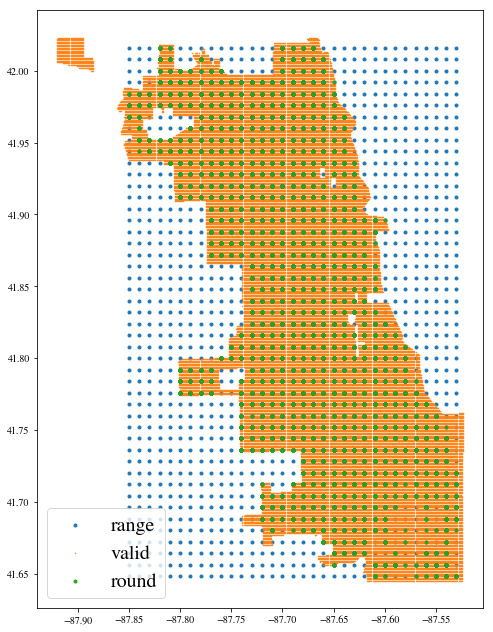

In [26]:

# save figures
plt.figure(figsize=(8, 11))
plt.scatter(X,Y, marker=".", label="range")
plt.scatter(valid_points[:, 0], valid_points[:, 1], marker=".", label="valid",s=1)
plt.scatter(crimes.X, crimes.Y, marker=".", label="round")
plt.legend(loc=3, prop={"size": 20})
plt.show()


2014-01-01 00:00:00
46


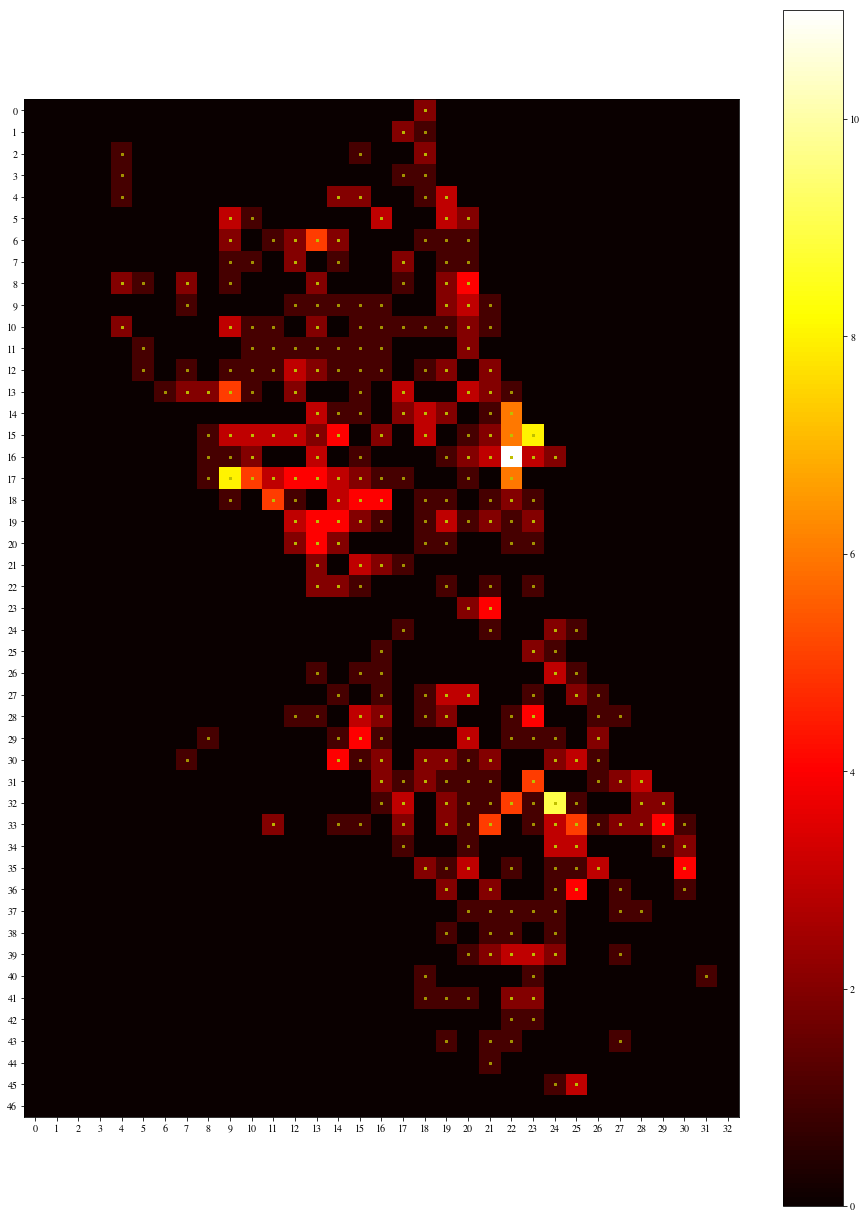

In [12]:
t = 0
print(t_range[t])
plt.figure(figsize=(16,22))
plt.imshow(crime_grids[t,0],cmap='hot')
plt.colorbar()
spots = A[A[:,0] == t]
print(max(spots[:,2]))
plt.scatter(y=y_size-1-spots[:,2],x=spots[:,1],c='y',marker='s',s=5,alpha=.7)
plt.yticks(range(y_size))
plt.xticks(range(x_size))
plt.show()

# plt.figure(figsize=(22,16))
# plt.imshow(crime_grids.max(0),cmap='viridis')
# plt.colorbar()
# spots = A
# plt.scatter(y=max(spots[:,2])-spots[:,2],x=spots[:,1],c='y',marker='s',s=5,alpha=.7)
# plt.yticks(range(y_size))
# plt.xticks(range(x_size))
# plt.show()

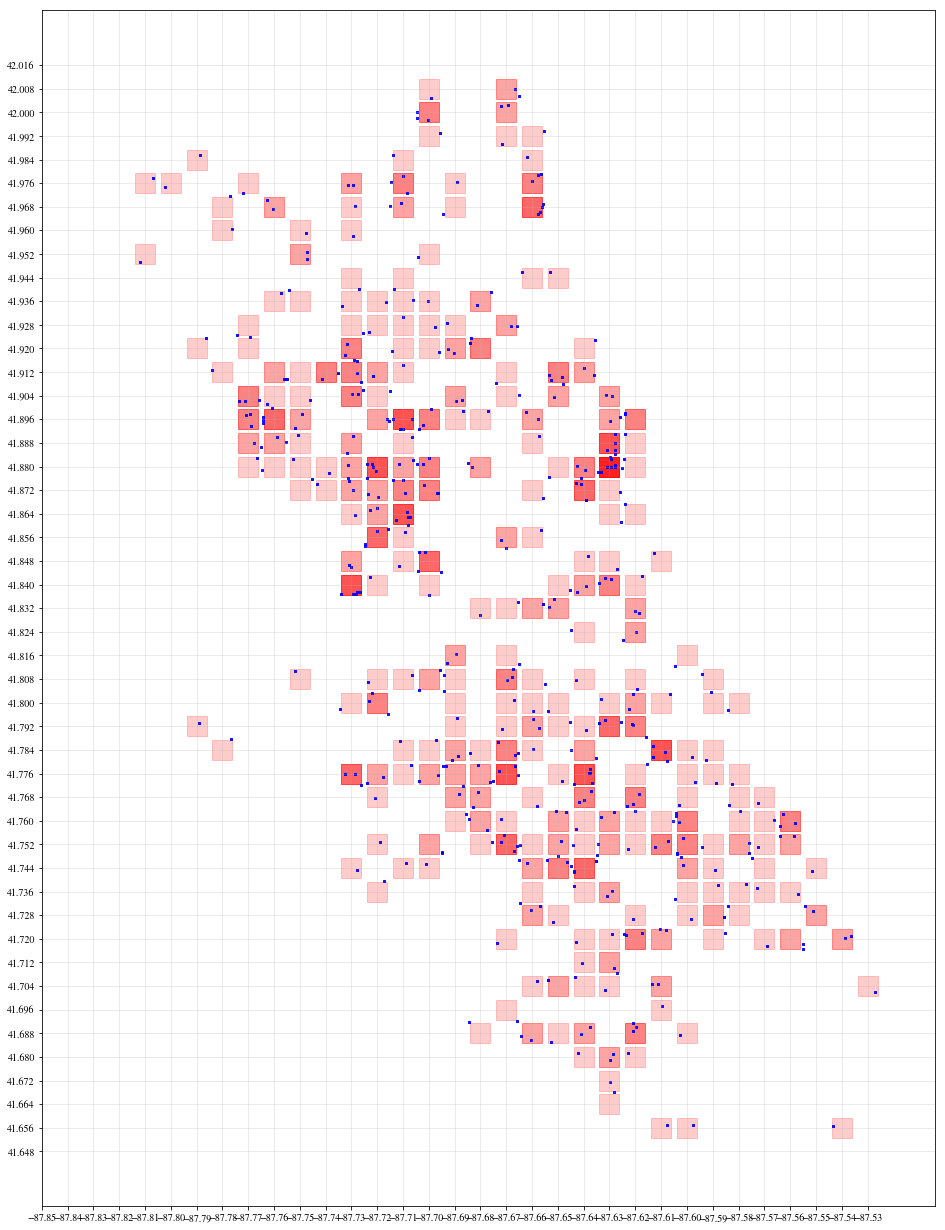

In [9]:
t = 50
time = t_range[t]
plt.figure(figsize=(16,22))
daily_crimes = crimes[crimes.Date.between(t_range[t],t_range[t+1])]
plt.scatter(y=daily_crimes.Y, x=daily_crimes.X,c='r',marker='s',s=380,alpha=.2)
plt.scatter(y=daily_crimes.Latitude, x=daily_crimes.Longitude,c='b',marker='s',s=2,alpha=.9)
plt.yticks(y_range)
plt.xticks(x_range)
plt.grid(alpha=0.3)
plt.show()


# Todo `AUC` over time and if re-training is needed

In [ ]:
np.stack()